In [1]:
import sys
import os

# Add parent directory to path to import dataset module
# For notebook, use os.getcwd() instead of __file__
notebook_dir = os.getcwd()
parent_dir = os.path.dirname(notebook_dir)
sys.path.insert(0, parent_dir)

import torch
from transformers import AutoTokenizer
from mamba.mamba_ssm.models.mixer_seq_simple import MambaLMHeadModel
from dataset.hotpot import HotpotQAIterator
from skip_layer_pre.utils import inference_logic, prefill_from_scratch
from tqdm import tqdm

device = 'cuda:0'
model_name = 'state-spaces/mamba-2.8b'

/home/hlife/Mamba-experiment/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Fetch an example for experiment
dataset = HotpotQAIterator('../dataset/HotpotQA/hotpot_train_v1.1.json').random_choose(1000, 42)
data = dataset[0]  # Get the first example
doc1 = data.get_useful()[0]
doc2 = data.get_useful()[1]
question = data.question

# Build prompt
doc1_prompt = f"Document 1: {doc1['title']}: {doc1['content']}\n\n"
doc2_prompt = f"Document 2: {doc2['title']}: {doc2['content']}\n\n"
few_shot_prompt = (
    "Q: Who is older, Alice or Bob?\n"
    "A: Alice\n\n"
    "Q: Are cats and dogs both mammals?\n"
    "A: yes\n\n"
    "Q: What color do red and blue make?\n"
    "A: purple\n\n"
)
question_prompt = f"Q: {question}\n\nA:"

# print(few_shot_prompt + doc1_prompt + doc2_prompt + question_prompt)

In [3]:
# Load model and tokenizer
model = MambaLMHeadModel.from_pretrained(model_name, device=device, dtype=torch.float16)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neox-20b")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

# Get cache result
full_promt = few_shot_prompt + doc1_prompt + doc2_prompt + question_prompt
full_inputids = tokenizer(full_promt, return_tensors="pt").input_ids.to(device)
full_cache , _ = prefill_from_scratch(model, full_inputids, device)
full_ssm_stack = torch.stack([full_cache.key_value_memory_dict[i][1] for i in range(len(full_cache.key_value_memory_dict))])[:, 0, :, :]

# Get ssm shape
layer_num, ssm_dim, ssm_size = full_ssm_stack.shape
(layer_num, ssm_dim, ssm_size)

/home/hlife/Mamba-experiment/mamba/mamba_ssm/utils/hf.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(resolved_archive_file, map_location=mapped_devic

(64, 5120, 16)

In [ ]:
from torch.nn.functional import cosine_similarity
full_ssm_layer_cossimilarity = torch.zeros((layer_num - 1, ssm_dim))
for i in range(layer_num - 1):
    full_ssm_layer_cossimilarity[i] = cosine_similarity(full_ssm_stack[i], full_ssm_stack[i + 1], dim=-1)

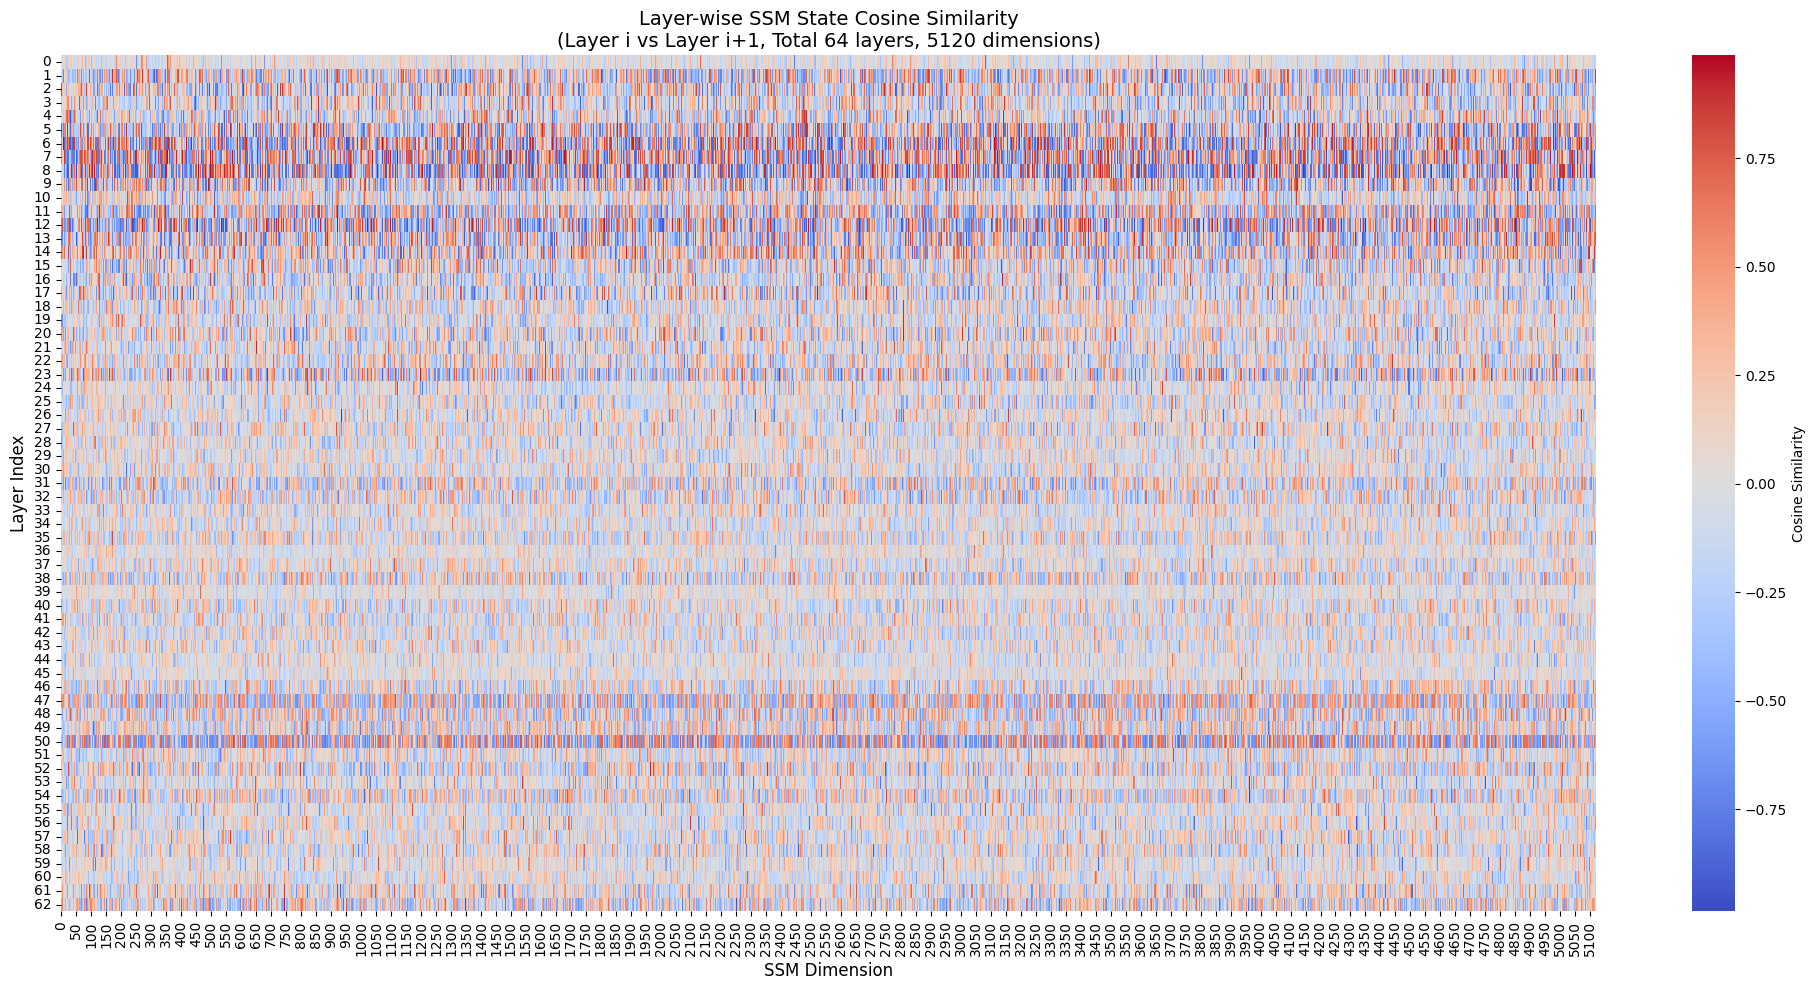

Shape: torch.Size([63, 5120])
Mean similarity: -0.0013
Std similarity: 0.3435
Min similarity: -0.9858
Max similarity: 0.9873


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# 创建热力图
plt.figure(figsize=(20, 10))
sns.heatmap(full_ssm_layer_cossimilarity.cpu().numpy(), 
            cmap='coolwarm', 
            center=0,
            cbar_kws={'label': 'Cosine Similarity'},
            xticklabels=50,  # 每50个维度显示一个刻度
            yticklabels=1)   # 每层都显示

plt.xlabel('SSM Dimension', fontsize=12)
plt.ylabel('Layer Index', fontsize=12)
plt.title(f'Layer-wise SSM State Cosine Similarity\n(Layer i vs Layer i+1, Total {layer_num} layers, {ssm_dim} dimensions)', fontsize=14)
plt.tight_layout()
plt.show()

# 显示统计信息
print(f"Shape: {full_ssm_layer_cossimilarity.shape}")
print(f"Mean similarity: {full_ssm_layer_cossimilarity.mean():.4f}")
print(f"Std similarity: {full_ssm_layer_cossimilarity.std():.4f}")
print(f"Min similarity: {full_ssm_layer_cossimilarity.min():.4f}")
print(f"Max similarity: {full_ssm_layer_cossimilarity.max():.4f}")

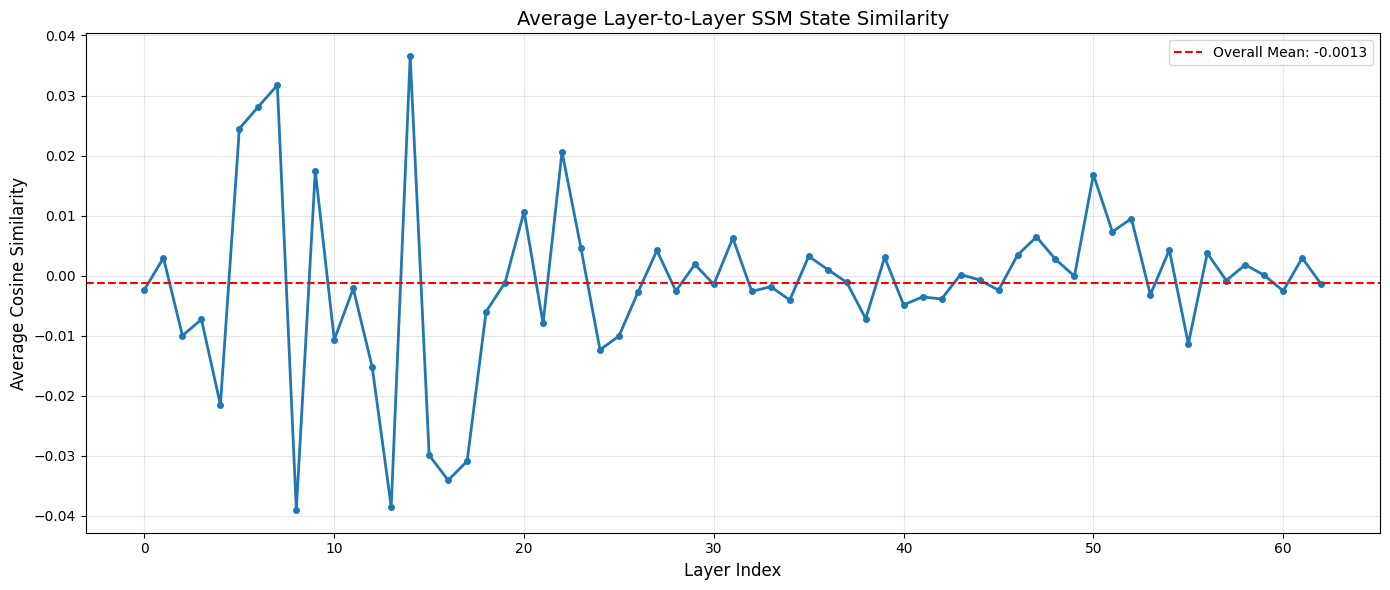

Layer-wise average similarity statistics:
Mean: -0.0013
Std: 0.0142
Min: -0.0390 (Layer 8)
Max: 0.0366 (Layer 14)


In [6]:
# 对每一层计算平均相似度
layer_avg_similarity = full_ssm_layer_cossimilarity.mean(dim=1).cpu().numpy()

# 绘制折线图
plt.figure(figsize=(14, 6))
plt.plot(range(len(layer_avg_similarity)), layer_avg_similarity, marker='o', linewidth=2, markersize=4)
plt.xlabel('Layer Index', fontsize=12)
plt.ylabel('Average Cosine Similarity', fontsize=12)
plt.title('Average Layer-to-Layer SSM State Similarity', fontsize=14)
plt.grid(True, alpha=0.3)
plt.axhline(y=layer_avg_similarity.mean(), color='r', linestyle='--', label=f'Overall Mean: {layer_avg_similarity.mean():.4f}')
plt.legend()
plt.tight_layout()
plt.show()

# 显示统计信息
print(f"Layer-wise average similarity statistics:")
print(f"Mean: {layer_avg_similarity.mean():.4f}")
print(f"Std: {layer_avg_similarity.std():.4f}")
print(f"Min: {layer_avg_similarity.min():.4f} (Layer {layer_avg_similarity.argmin()})")
print(f"Max: {layer_avg_similarity.max():.4f} (Layer {layer_avg_similarity.argmax()})")